In [539]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import signal
import copy

def kern2mat(H, size):
    N = H.size
    half = int((N - 1) / 2)
    Nout, Mout = size
    if Nout == Mout:
        return linalg.toeplitz(np.r_[H[half:], np.zeros(Nout - half)], np.r_[H[half:], np.zeros(Mout-half)])
    else:
        return linalg.toeplitz(np.r_[H, np.zeros(Nout - N)], np.r_[H[-1], np.zeros(Mout-1)])

def mult_diag(d, mtx, left=True):
    """Multiply a full matrix by a diagonal matrix.
    This function should always be faster than dot.

    Input:
      d -- 1D (N,) array (contains the diagonal elements)
      mtx -- 2D (N,N) array

    Output:
      mult_diag(d, mts, left=True) == dot(diag(d), mtx)
      mult_diag(d, mts, left=False) == dot(mtx, diag(d))
    """
    if left:
        return (d*mtx.T).T
    else:
        return d*mtx

# Image reconstruction toy optimization

This is an example of a more realistic problem with a larger number of parameters and constraints.

Consider measuring $y$, which is the convolution of the quantity we wish to measure $x$ with an impulse response function $H$, and corrupted by additive Gaussian noise with standard deviation $\sigma$. We can write the model as,

$$y \sim \mathcal{N}(H \ast x, \sigma)$$

Let's consider the maximum likelihood estimate of $x$ given $y$.
We can write this as a linear least squares problem,

$$\begin{align}
r& = y - A x \\
\end{align}$$

with the objective,

$$\min \frac{1}{2 \sigma ^2} \lVert r \rVert ^2 $$

**What can we say about this problem?**
- Linear least squares
- Convex (local minimum = global minimum)
- Potentially under-determined (for $N$ measured data points, convolution kernel of size $M$, it is natural to model $M + N - 1$ unknowns)



### Additional information
$x$ constrained to be positive.

One possible way to constrain $x$ to be positive is to introduce $\hat{x}$ defined as $x = e^\hat{x}$, and optimize with respect to $\hat{x}$.

$$ r = y - A e^{\hat{x}} $$


**What can we say about this problem?**
- Still convex!
- Potentially under-determined

### Additional information
Add an exponential prior on $x$ (equal for each x-coordinate to be estimated), we have,

$$ f(\hat{x}) = \frac{1}{2 \sigma^2}r^T r + (\hat{x} - \frac{e^{\hat{x}}}{\mu_x})$$

Then we have,

$$\begin{align}
J& = \operatorname{diag} (e^\hat{x}) \, A &\\
\nabla f&  = J^T r + I - \frac{e^{\hat{x}}}{\mu_x}
\end{align}$$

- Not underdetermined
- Still convex! (Checked using `Convex.jl`)
- Still use residuals to calculate *most* of $\nabla f$

# Example

In [701]:
mu_x = 0.5

In [702]:
h = np.array([0.25, 0.5, 0.25])
M = h.size
Nout = 10
Nin = Nout +h -1
A = kern2mat(h, (14, 12))
A = A[2:-2]

In [703]:
x_mid = np.array([0.1, 0.2, 0.6, 0.5, 0.3, 0.03, 0.15, 0.3, 0.6, 0.3])

x_exact = np.r_[[0.1], x_mid, [0.2]]
x_exact = x_exact.reshape((-1, 1))


x_0 = np.exp(xh_0)

def J(A, x):
    return mult_diag(A, np.squeeze(x), False)

In [704]:
r0 = y_exact - np.dot(A,x_0)
J0 = J(A, x_0)

In [710]:
def makef(A, h, y, mu_x, w):
    def ffgrad(xhat):
        x = np.exp(xhat)
        r = signal.convolve(x, h, 'valid') - y.flatten()
        grad_f = (np.dot(A.T, r) * x + (1 - x/mu_x) / 2)
        f = (w*sum(r**2)/2 - 0.5*sum(xhat) + 0.5*sum(x/mu_x))
        return f, grad_f
    def f(xhat):
        x = np.exp(xhat)
        r = signal.convolve(x, h, 'valid') - y.flatten()
        return w*sum(r**2)/2 - 0.5*sum(xhat) + 0.5*sum(x/mu_x)
    def fgrad(xhat):
        x = np.exp(xhat)
        r = signal.convolve(x, h, 'valid') - y.flatten()
        return w * (np.dot(A.T, r) * x) + (x/mu_x - 1.0) / 2.0
    return f, fgrad

In [718]:
np.random.seed(12389384)
sigma2fit = 0.001
sigma2 = 0.001
yn = y_exact.flatten() + np.random.randn(y_exact.size)*sigma2**0.5 
mu_x = 0.28
xh_0 = np.zeros_like(x_exact) + np.log(mu_x)

f, fgrad = makef(A, h, yn, mu_x, 1.0/sigma2fit)

In [719]:
out = optimize.fmin_powell(f, xh_0, full_output=True)

Optimization terminated successfully.
         Current function value: 16.347943
         Iterations: 16
         Function evaluations: 2325


In [720]:
out = optimize.fmin_bfgs(f, xh_0, fprime=fgrad, full_output=True, gtol=1e-7)

Optimization terminated successfully.
         Current function value: 16.329003
         Iterations: 39
         Function evaluations: 49
         Gradient evaluations: 49


In [721]:
xhat_opt = out[0]
x_opt = np.exp(xhat_opt)

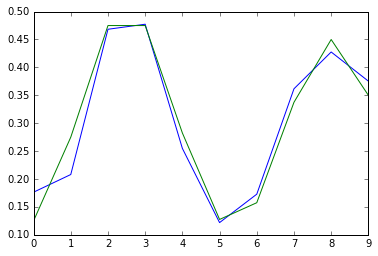

In [722]:
plt.plot(signal.convolve(x_opt, h, 'valid'))
plt.plot(y_exact)

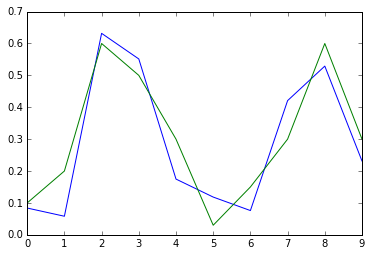

In [723]:
plt.plot(x_opt[1:-1])
plt.plot(x_exact[1:-1])

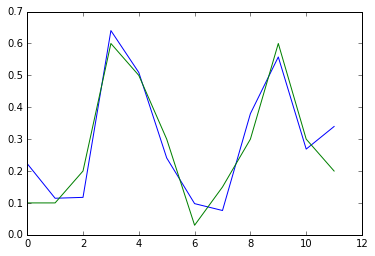

In [700]:
plt.plot(x_opt)
plt.plot(x_exact)